In [5]:
import os
import sys
sys.path.append("..")
import torch
import subprocess
import traceback
import warnings
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

from tqdm import tqdm
# n.pyimport hydra
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from src.metric import LWLRAP
from src.models import get_model
import src.configuration as C
import src.utils as utils
from src.metric import LWLRAP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger

In [2]:
PSEUDO_THR = 0.9

# config
config_filename = 'EfficientNetSED001.yaml'
config = utils.load_config(f"configs/{config_filename}")
device = "cuda"

# data
df, datadir = C.get_metadata(config)
all_recording_ids = df["recording_id"].values

config["loader"]["valid"]["batch_size"] = 1

loaders = {
    phase: C.get_loader(df_, datadir, config, phase)
    for df_, phase in zip([df], ["valid"])
}

In [4]:

pseudo_label_dict_list = []
for fold in range(5):
    # model
    print(f"fold-{fold}")
    model = get_model(config)
    model_name = "EfficientNetSED"
    output_dir = Path("output/0123_181828")
    try:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
    except:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
    model.load_state_dict(ckpt['state_dict'])
    model.eval().to(device)


    output_key = "logit"
    pseudo_label_dict = {}
    with torch.no_grad():
        # xは複数のlist
        for (x_list, y), recording_id in tqdm(zip(loaders['valid'], all_recording_ids)):
            batch_size = x_list.shape[0]
            x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
            x = x.to(device)
            output = model.model(x)
            output = output[output_key]
            output = output.view(batch_size, -1, 24)  # (1, 6, 24)
            preds = output.sigmoid().detach().cpu().numpy()[0]  # 1batchを前提に0こ目だけ取得

            # どれかのクラスが反応している場合、閾値以上のクラスを追加
            labels = []
            # labels = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[]}  # 0: 0~10s 1:10~20s ... 5:50~60s
            for i in range(preds.shape[0]):  # 6音声を１つずつ処理
                pred = preds[i]
                if (pred > 0.9).any():  # 1つのクラスでも0.9以上があればラベル候補とする
                    idx = np.where(pred > PSEUDO_THR)[0]
                    _lab = np.eye(24)[idx]
                    _lab = (_lab.sum(0) > 0).astype(int)  # (1, 24)
                else:
                    _lab = np.zeros(24)
                labels.append(_lab)
            labels = np.stack(labels).astype(int)  # [(1,24)*6] -> (6, 24)
            if labels.sum() == 0:  # 1つのラベルもついていない場合は次のbatchへ
                continue
            pseudo_label_dict[recording_id] = labels

    pseudo_label_dict_list.append(pseudo_label_dict)

fold-0
Loaded pretrained weights for efficientnet-b2
1216it [00:24, 49.06it/s]
fold-1
Loaded pretrained weights for efficientnet-b2
1216it [00:24, 49.42it/s]
fold-2
Loaded pretrained weights for efficientnet-b2
1216it [00:25, 48.58it/s]
fold-3
Loaded pretrained weights for efficientnet-b2
1216it [00:25, 48.30it/s]
fold-4
Loaded pretrained weights for efficientnet-b2
1216it [00:25, 47.93it/s]


## 60sをtargetに

In [5]:
pseudo_label_dict_5fold = {}
for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((6, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)
    new_label = (new_label.sum(0) > 0).astype(int)  # 6分割されている音声を1つにまとめる(for 60s)
    if new_label.sum() == 0:  
        pass
    else:
        pseudo_label_dict_5fold[recording_id] = new_label

In [6]:
pseudo_df = pd.DataFrame(pseudo_label_dict_5fold).T
pseudo_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
003bec244,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
006ab765f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
007f87ba2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0099c367b,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
009b760e6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe8d9ac40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fea6b438a,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ff2eb9ce5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ffb8d8391,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
pseudo_df = pseudo_df.reset_index().rename(columns={'index':'recording_id'})
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,003bec244,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,006ab765f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,007f87ba2,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0099c367b,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128,fea6b438a,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1129,ff2eb9ce5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1130,ffb8d8391,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
pseudo_df['t_min'] = 0
pseudo_df['t_max'] = 60

In [9]:
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,60
1,006ab765f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,60
2,007f87ba2,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
3,0099c367b,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,60
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
1128,fea6b438a,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,60
1129,ff2eb9ce5,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60
1130,ffb8d8391,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,60


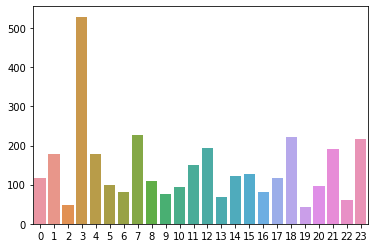

In [11]:
import seaborn as sns 

sns.barplot(pseudo_df.iloc[:, 1:].sum().index, pseudo_df.iloc[:, 1:].sum().values)

In [10]:
pseudo_df.to_csv("./input/rfcx-species-audio-detection/train_ps60.csv", index=False)

## 10sをtargetに

In [6]:
pseudo_label_dict = {"step0":{}, "step1":{}, "step2":{}, "step3":{}, "step4":{}, "step5":{}}  # step0:0~10s step1:10~20s...step5:50~60s

In [10]:
pseudo_label_dict_all = {"step0":{}, "step1":{}, "step2":{}, "step3":{}, "step4":{}, "step5":{}}  # step0:0~10s step1:10~20s...step5:50~60s

for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((6, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)  # (6, 24)?
    if new_label.sum() == 0:  
        pass
    else:
        for i in range(6):
            pseudo_label_dict_all[f"step{i}"][recording_id] = new_label[i]

In [13]:
pseudo_all_df = pd.DataFrame()
for i in range(6):
    pseudo_df = pd.DataFrame(pseudo_label_dict_all[f"step{i}"]).T
    pseudo_df = pseudo_df.reset_index().rename(columns={'index':'recording_id'})
    pseudo_df["t_min"] = i*10
    pseudo_df["t_max"] = (i+1)*10
    pseudo_all_df = pd.concat([pseudo_all_df, pseudo_df])

In [16]:
pseudo_all_df[pseudo_all_df['recording_id']=='003bec244']

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,10,20
0,003bec244,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,20,30
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,30,40
0,003bec244,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,40,50
0,003bec244,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,50,60


In [19]:
pseudo_all_df.reset_index(drop=True)

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,003bec244,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
1,006ab765f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,007f87ba2,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0099c367b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,fe8d9ac40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50,60
6788,fea6b438a,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,50,60
6789,ff2eb9ce5,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,50,60
6790,ffb8d8391,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,50,60


In [20]:
pseudo_all_df.to_csv("./input/rfcx-species-audio-detection/train_ps10.csv", index=False)

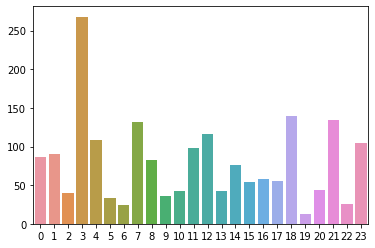

In [18]:
import seaborn as sns

sns.barplot(pseudo_all_df.iloc[:, 1:-2].sum().index, pseudo_df.iloc[:, 1:-2].sum().values)

## FPデータを対象に


In [6]:
PSEUDO_THR = 0.9

# config
config_filename = 'EfficientNetSED001.yaml'
config = utils.load_config(f"configs/{config_filename}")
device = "cuda"

In [10]:
config['data']['use_train_data'] = ['fp']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,data_type
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000,fp
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500,fp
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500,fp
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000,fp
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984,fp
...,...,...,...,...,...,...,...,...
7776,ffd88cd84,14,1,3.2000,2531.2500,3.7867,5531.2500,fp
7777,ffebe7313,1,1,35.2000,3843.7500,36.0960,5625.0000,fp
7778,fff163132,17,4,22.5547,1312.5000,25.0880,7406.2500,fp
7779,fff163132,14,1,37.0827,2531.2500,37.6693,5531.2500,fp


In [77]:
# data
df, datadir = C.get_metadata(config)
all_recording_ids = df["recording_id"].values

config["loader"]["valid"]["batch_size"] = 1

loaders = {
    phase: C.get_loader(df_, datadir, config, phase)
    for df_, phase in zip([df], ["valid"])
}

3958


In [78]:
df['recording_id'].nunique()

3958

In [14]:

pseudo_label_dict_list = []
for fold in range(5):
    # model
    print(f"fold-{fold}")
    model = get_model(config)
    model_name = "EfficientNetSED"
    output_dir = Path("output/0123_181828")
    try:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}-v0.ckpt')  # TODO foldごとのモデルを取得できるようにする
    except:
        ckpt = torch.load(output_dir / f'{model_name}-{fold}.ckpt')  # TODO foldごとのモデルを取得できるようにする
    model.load_state_dict(ckpt['state_dict'])
    model.eval().to(device)


    output_key = "logit"
    pseudo_label_dict = {}
    with torch.no_grad():
        # xは複数のlist
        for (x_list, y), recording_id in tqdm(zip(loaders['valid'], all_recording_ids)):
            batch_size = x_list.shape[0]
            x = x_list.view(-1, x_list.shape[2], x_list.shape[3], x_list.shape[4])  # batch>1でも可
            x = x.to(device)
            output = model.model(x)
            output = output[output_key]
            output = output.view(batch_size, -1, 24)  # (1, 6, 24)
            preds = output.sigmoid().detach().cpu().numpy()[0]  # 1batchを前提に0こ目だけ取得

            # どれかのクラスが反応している場合、閾値以上のクラスを追加
            labels = []
            for i in range(preds.shape[0]):  # 6音声を１つずつ処理
                pred = preds[i]
                if (pred > 0.9).any():  # 1つのクラスでも0.9以上があればラベル候補とする
                    idx = np.where(pred > PSEUDO_THR)[0]
                    _lab = np.eye(24)[idx]
                    _lab = (_lab.sum(0) > 0).astype(int)  # (1, 24)
                else:
                    _lab = np.zeros(24)
                labels.append(_lab)
            labels = np.stack(labels).astype(int)  # [(1,24)*6] -> (6, 24)
            if labels.sum() == 0:  # 1つのラベルもついていない場合は次のbatchへ
                continue
            pseudo_label_dict[recording_id] = labels

    pseudo_label_dict_list.append(pseudo_label_dict)

fold-0
Loaded pretrained weights for efficientnet-b2
7781it [02:43, 47.49it/s]
fold-1
Loaded pretrained weights for efficientnet-b2
7781it [02:45, 46.89it/s]
fold-2
Loaded pretrained weights for efficientnet-b2
7781it [02:44, 47.30it/s]
fold-3
Loaded pretrained weights for efficientnet-b2
7781it [02:50, 45.67it/s]
fold-4
Loaded pretrained weights for efficientnet-b2
7781it [02:47, 46.40it/s]


In [40]:
len(all_recording_ids)

7781

In [115]:
pseudo_label_dict_5fold = {}
for recording_id in all_recording_ids:  # recordingのループ
    labels = []
    # 任意の音声の5fold分のpsuedo label候補を取り出す
    for pseudo_label_dict in pseudo_label_dict_list:  # 5foldのループ
        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        try:
            label = pseudo_label_dict[recording_id]
        except KeyError:
            label = np.zeros((6, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 3).astype(int)
    new_label = (new_label.sum(0) > 0).astype(int)  # 6分割されている音声を1つにまとめる(for 60s)
    if new_label.sum() == 0:
        pass
    else:
        pseudo_label_dict_5fold[recording_id] = new_label

In [116]:
pseudo_df = pd.DataFrame(pseudo_label_dict_5fold).T
pseudo_df = pseudo_df.reset_index().rename(columns={'index':'recording_id'})
pseudo_df['t_min'] = 0
pseudo_df['t_max'] = 60
pseudo_df

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
0,00204008d,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
1,003b04435,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
2,005f1f9a5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,60
3,0072f0839,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
4,0079ff47b,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,ffc51b999,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
3834,ffc6031f8,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
3835,ffd88cd84,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60
3836,ffebe7313,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,60


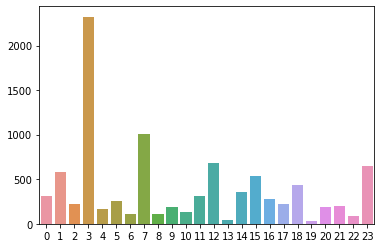

In [117]:
import seaborn as sns 

sns.barplot(pseudo_df.iloc[:, 1:-2].sum().index, pseudo_df.iloc[:, 1:-2].sum().values)

In [118]:
pseudo_df.iloc[:, 1:-2].sum(axis=1).value_counts()

2    1324
3    1173
1     738
4     484
5     103
6      15
7       1
dtype: int64

In [126]:
# single labelは除外/多すぎるやつも除外
pseudo_df2 = pseudo_df[~pseudo_df.iloc[:, 1:-2].sum(axis=1).isin([1, 5, 6,7])]

In [127]:
# # single labelは除外/多すぎるやつも除外
# pseudo_df3 = pseudo_df[pseudo_df.iloc[:, 1:-2].sum(axis=1).isin([1])]

In [128]:
pseudo_df2.iloc[:, 1:-2].sum(axis=1).value_counts()

2    1324
3    1173
4     484
dtype: int64

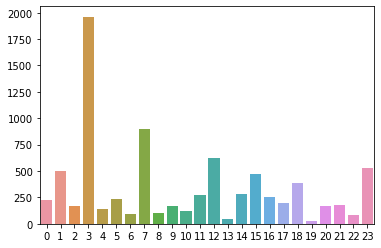

In [129]:
sns.barplot(pseudo_df2.iloc[:, 1:-2].sum().index, pseudo_df2.iloc[:, 1:-2].sum().values)

In [137]:
pseudo_df3 = pseudo_df2.drop(pseudo_df2[pseudo_df2[3]==1].sample(1400).index)

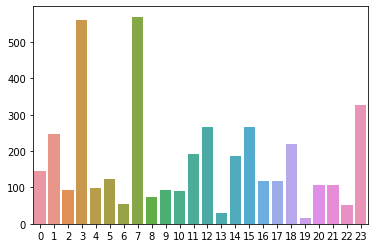

In [138]:
sns.barplot(pseudo_df3.iloc[:, 1:-2].sum().index, pseudo_df3.iloc[:, 1:-2].sum().values)

In [139]:
pseudo_df3

,recording_id,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,t_min,t_max
1,003b04435,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
2,005f1f9a5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,60
6,00834f88e,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,60
7,008c9c381,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60
9,009fbc7b4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831,ff858780b,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,60
3833,ffc51b999,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
3834,ffc6031f8,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,60
3835,ffd88cd84,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,60


In [140]:
pseudo_df3.to_csv("./input/rfcx-species-audio-detection/train_fp_vote3_numlabel234_decrease3.csv", index=False)